In [1]:
import os
from timeit import default_timer as timer
import numpy as np
import scipy.linalg as la
import theano as th
import theano.tensor as tt
import matplotlib.pyplot as plt
import seaborn as sns
from dgm import model_wrappers, lotka_volterra, utils
import scipy.optimize as opt
import hmc.constrained, hmc.unconstrained
from auxpm import samplers as pm_samplers
from choldate import cholupdate
sns.set_style('white')
%matplotlib inline

## Set up experiment directories

In [2]:
base_dir = os.path.dirname(os.getcwd())
exp_dir = os.path.join(base_dir, 'results', 'lotka-volterrra')
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)

In [3]:
logger = utils.setup_logger(exp_dir)

## Define generators constants

Generator takes a dict of fixed parameters / constants specifying behaviour as second argument.

In [4]:
consts = {
    'dt': 1., # integrator time step
    'n_param': 4, # number of model parameters
    'n_step': 50, # number of time steps to simulate
    'noise_std': 1., # noise standard deviation
    'y1_init': 100, # initial prey population
    'y2_init': 100, # initial predator population
    'log_z_mean': -2., # prior log-normal mean
    'log_z_std': 1.,  # prior log-normal std.
    'seed': 1234, # random number generator seed
}

Define seeded random number generator.

In [5]:
rng = np.random.RandomState(consts['seed'])

## Set up model

Generator Jacobian $\frac{\partial \boldsymbol{G}_y}{\partial \boldsymbol{u}} = \boldsymbol{J}$ can be partioned into a dense block $\boldsymbol{M}$ and lower triangular block $\boldsymbol{L}$ i.e. $\boldsymbol{J} = \left[ \boldsymbol{M} ~ \boldsymbol{L} \right]$ due to the autoregressive structure of generator. The Jacobian Gram matrix $\boldsymbol{J} \boldsymbol{J}^{\rm T}$ can therefore be decomposed as the sum of the products $\boldsymbol{M}\boldsymbol{M}^{\rm T}$ and $\boldsymbol{L}\boldsymbol{L}^{\rm T}$. As the number of columns of $\boldsymbol{M}$ (4, the number of model parameters) is less than the number of rows (100, the dimension of the observations), the Cholesky decomposition of $\boldsymbol{L}\boldsymbol{L}^{\rm T} + \boldsymbol{M}\boldsymbol{M}^{\rm T}$ can be efficiently computed by doing low-rank Cholesky updates of $\boldsymbol{L}$ by the columns of $\boldsymbol{M}$.

In [6]:
def calc_gram_chol(jac):
    gram_chol = jac[:, -jac.shape[0]:].T * 1.
    for col in jac[:, :-jac.shape[0]].T:
        cholupdate(gram_chol, col.copy())
    return gram_chol, False

Compile model wrapper object. This takes a Theano graph based generator definition and compiles the function needed by the constrained HMC sampler to perform inference.

In [7]:
model = model_wrappers.MinimalDifferentiableGenerativeModel(
    generator=lotka_volterra.population_seq_generator,
    constants=consts,
    calc_gram_chol=calc_gram_chol
)

2017-04-19 03:35:35 dgm.model_wrappers:INFO Compiling generator function...
2017-04-19 03:35:43 dgm.model_wrappers:INFO ... finished in 8.4s
2017-04-19 03:35:43 dgm.model_wrappers:INFO Compiling generator Jacobian...
2017-04-19 03:35:49 dgm.model_wrappers:INFO ... finished in 6.0s
2017-04-19 03:35:49 dgm.model_wrappers:INFO Compiling energy gradient...
2017-04-19 03:36:10 dgm.model_wrappers:INFO ... finished in 21.1s
2017-04-19 03:36:10 dgm.model_wrappers:INFO Compiling base energy function...
2017-04-19 03:36:10 dgm.model_wrappers:INFO ... finished in 0.6s


Also compile a batch generator function for visualising samples.

In [8]:
u = tt.matrix('u')
x = lotka_volterra.population_seq_generator(u, consts)
generator = th.function([u], x)

Define helper function for visualising samples.

In [9]:
def scatter_grid(param_samples, true_vals, fig_size=(6, 6)):
    n_param = param_samples.shape[1]
    fig, axes = plt.subplots(n_param, n_param, figsize=fig_size)
    for i in range(n_param):
        for j in range(n_param):
            if i == j:
                sns.kdeplot(param_samples[:, i], ax=axes[i, j])
            elif i < j:
                axes[i, j].plot(param_samples[:, j], param_samples[:, i], '.', ms=2)
                axes[i, j].plot([true_vals[j]], [true_vals[i]], 'r*')
            else:
                sns.kdeplot(param_samples[:, j], param_samples[:, i], cmap='Blues',
                            shade=True, shade_lowest=False, n_levels=10, ax=axes[i, j])
                axes[i, j].plot([true_vals[j]], [true_vals[i]], 'r*')
            axes[i, j].set_xticklabels([])
            axes[i, j].set_yticklabels([])
        axes[i, 0].set_ylabel('$u_{0}$'.format(i), fontsize=14)
        axes[-1, i].set_xlabel('$u_{0}$'.format(i), fontsize=14)
    fig.tight_layout(pad=0)
    return fig, axes

## Observed data

Load observed image region to condition on.

In [10]:
z_obs = np.array([0.4, 0.005, 0.05, 0.001])
ns_obs = rng.normal(size=2 * consts['n_step'])
u_obs = np.concatenate([
    (np.log(z_obs) - consts['log_z_mean']) / consts['log_z_std'],
    ns_obs
])[None]
model.y_obs = generator(u_obs)[0]

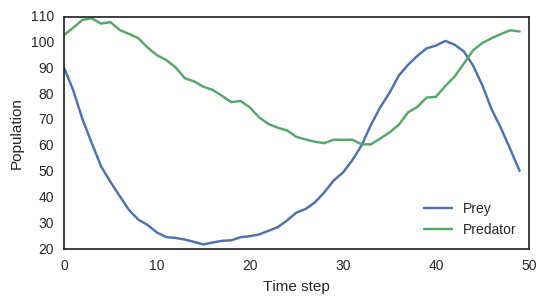

In [11]:
fig  = plt.figure(figsize=(6, 3))
ax = fig.add_subplot(111)
ax.plot(model.y_obs[::2])
ax.plot(model.y_obs[1::2])
ax.set_xlabel('Time step')
ax.set_ylabel('Population')
ax.legend(['Prey', 'Predator'], loc='best')

## Define number of independent chains to run for each experiment

In [12]:
n_run = 1

## Constrained HMC

Set up geodesic integrator based constrained HMC sampler using compiled model functions and define sampler settings.

In [13]:
constr_sampler = hmc.constrained.LfGbabConstrainedIsotropicHmcSampler(
    energy_func=model.energy_func,
    constr_func=model.constr_func,
    energy_grad=model.energy_grad,
    constr_jacob=model.constr_jacob,
    prng=rng,
    mom_resample_coeff=1.,
    tol=1e-8,
    max_iters=100,
    n_inner_update=3,
    check_reverse=True,
)
dt = 0.25
n_step_per_sample = (4, 8)
n_sample = 200
n_warm_up = 10
rng.seed(consts['seed'])

Use `scipy.opt.fsolve` to find set of initial constraint satisfying $\boldsymbol{u}$.

In [14]:
u_inits = np.zeros((n_run, consts['n_param'] + consts['n_step'] * 2))
for r in range(n_run):
    u_inits[r, :consts['n_param']] = rng.normal(size=consts['n_param']) * 0.1 - 4
    u_ = opt.fsolve(
        lambda u_: model.constr_func(np.r_[u_inits[r, :consts['n_param']], u_]), 
        np.zeros(consts['n_step'] * 2),
        xtol=1e-12,
    )
    u_inits[r, consts['n_param']:] = u_
    assert np.max(abs(model.constr_func(u_inits[r]))) < 1e-10

Run sampling and visualise computed samples as grids of images.

2017-04-19 03:36:12 root:INFO Starting run 1...
2017-04-19 03:37:15 root:INFO ...completed, accepted: 0.990476190476, run time: 63.1s


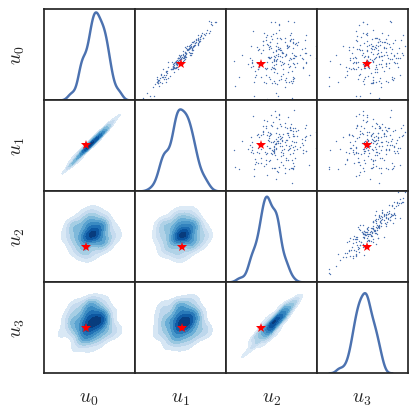

In [15]:
for r in range(n_run):
    try:
        u_init = u_inits[r]
        logger.info('Starting run {0}...'.format(r+1))
        start_time = timer()
        u_samples, p_samples, accept = constr_sampler.get_samples(
            pos=u_init.copy(), dt=dt, 
            n_step_per_sample=n_step_per_sample, 
            n_sample=n_sample + n_warm_up
        )
        run_time = timer() - start_time
        logger.info('...completed, accepted: {0}, run time: {1:.1f}s'
                    .format(accept, run_time))
        fig, axes = scatter_grid(
            u_samples[n_warm_up:, :consts['n_param']], 
            u_obs[0, :consts['n_param']], (4, 4))
        plt.show()
        np.savez(os.path.join(exp_dir, 'chmc-results-{0}.npz'.format(r+1)),
            u_samples=u_samples, accept=accept, run_time=run_time, 
            n_step_per_sample=n_step_per_sample, dt=dt, n_warm_up=n_warm_up)
    except Exception as e:
        logger.exception('Error encountered run {0}:'.format(r+1))

## ABC reject

In [16]:
def sample_abc_reject(n_sample, epsilon, rng):
    us = rng.normal(size=(n_sample, consts['n_param'] + consts['n_step'] * 2))
    ys = generator(us)
    diffs = ys - model.y_obs
    dists = (diffs**2).sum(-1)
    accepts = dists < epsilon
    print('Num accepted: {0}'.format(accepts.sum()))
    return us[accepts]

In [17]:
us_abc_reject = sample_abc_reject(1000000, 1000., rng)

Num accepted: 0


## PM ABC MCMC (uniform kernel)

In [18]:
def log_f_estimator(u_z, u_y, epsilon):
    y = model.generator_func(np.r_[u_z, u_y])
    diff = y - model.y_obs
    return np.log((diff ** 2).sum()**0.5 < epsilon) - 0.5 * u_z.dot(u_z)

def prop_sampler(u_z, prop_scales):
    return u_z + prop_scales * rng.normal(size=u_z.shape[0])

In [19]:
n_sample = 200000
n_warm_up = 20000
rng.seed(consts['seed'])

2017-04-19 03:37:29 root:INFO Start runs for epsilon=1000
2017-04-19 03:37:29 root:INFO Starting run 1...


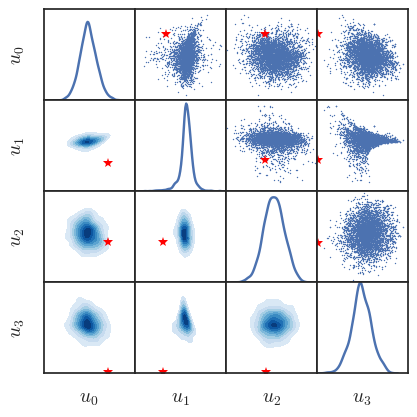

2017-04-19 03:39:04 root:INFO ...run 1 completed: time taken 76.4s, accepted 0.37795
2017-04-19 03:39:04 root:INFO Start runs for epsilon=100
2017-04-19 03:39:04 root:INFO Starting run 1...
2017-04-19 03:40:20 root:INFO ...run 1 completed: time taken 76.5s, accepted 4.54545454542e-06


In [20]:
for epsilon, step_size in [(1000, 0.2), (100, 0.001)]:
    logger.info('Start runs for epsilon={0}'.format(epsilon))
    pmmh_sampler = pm_samplers.PMMHSampler(
        lambda u_z: log_f_estimator(
            u_z, rng.normal(size=consts['n_step'] * 2), epsilon),
        None, prop_sampler, np.ones(consts['n_param']) * step_size, rng
    )
    for r in range(n_run):
        u_z_init = u_inits[r, :consts['n_param']]
        logger.info('Starting run {0}...'.format(r+1))
        start_time = timer()
        u_z_pmmh, n_reject = pmmh_sampler.get_samples(u_z_init.copy(), n_sample + n_warm_up)
        run_time = timer() - start_time
        accept = 1. - n_reject / float(n_sample + n_warm_up)
        if (n_sample + n_warm_up - n_reject) > 1:
            fig, axes = scatter_grid(
                u_z_pmmh[n_warm_up::50], u_obs[0, :consts['n_param']], (4, 4))
            plt.show()
        logger.info('...run {0} completed: time taken {1:.1f}s, accepted {2}'
                    .format(r+1, run_time, accept))
        np.savez(os.path.join(exp_dir, 'pmmh-eps-{0}-results-{1}.npz'.format(epsilon, r + 1)),
                 u_z_pmmh=u_z_pmmh, accept=accept, run_time=run_time, 
                 step_size=step_size, n_warm_up=n_warm_up)

## PM Slice (Ell) ABC MCMC (uniform kernel)

In [21]:
def log_f_estimator_ess(u_z, u_y, epsilon):
    y = model.generator_func(np.r_[u_z, u_y])
    diff = y - model.y_obs
    return np.log((diff ** 2).sum()**0.5 < epsilon)

In [22]:
n_sample = 10000
n_warm_up = 1000
rng.seed(consts['seed'])

2017-04-19 03:40:21 root:INFO Start runs for epsilon=100
2017-04-19 03:40:21 root:INFO Starting run 1...


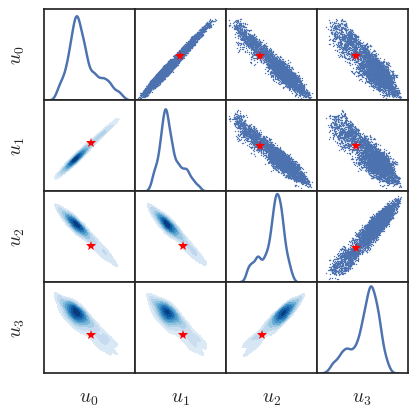

2017-04-19 03:41:28 root:INFO ...run 1 completed: time taken 43.4s
2017-04-19 03:41:28 root:INFO Start runs for epsilon=10
2017-04-19 03:41:28 root:INFO Starting run 1...


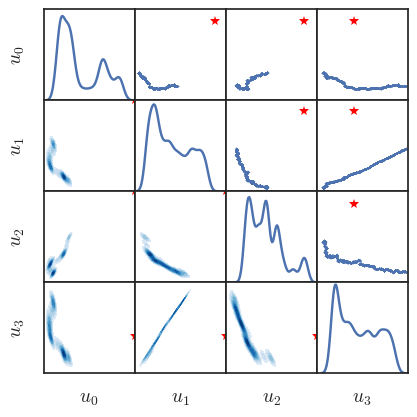

2017-04-19 03:43:27 root:INFO ...run 1 completed: time taken 96.3s


In [23]:
for epsilon in [100, 10]:
    logger.info('Start runs for epsilon={0}'.format(epsilon))
    pmess_sampler = pm_samplers.APMEllSSPlusEllSSSampler(
        lambda u_y, u_z, cached=None: (
            log_f_estimator_ess(u_z, u_y, epsilon), None),
        lambda: rng.normal(size=consts['n_step'] * 2),
        lambda: rng.normal(size=consts['n_param']), rng, 100
    )
    for r in range(n_run):
        u_z_init = u_inits[r, :consts['n_param']]
        u_y_init = u_inits[r, consts['n_param']:]
        logger.info('Starting run {0}...'.format(r+1))
        start_time = timer()
        u_z_pmess = pmess_sampler.get_samples(
            u_z_init.copy(), n_sample + n_warm_up, u_y_init.copy())
        run_time = timer() - start_time
        fig, axes = scatter_grid(
            u_z_pmess[n_warm_up::2], u_obs[0, :consts['n_param']], (4, 4))
        plt.show()
        logger.info('...run {0} completed: time taken {1:.1f}s'
                    .format(r+1, run_time))
        np.savez(os.path.join(exp_dir, 'pmess-eps-{0}-results-{1}.npz'.format(epsilon, r + 1)),
                 epsilon=epsilon, u_z_pmess=u_z_pmess, run_time=run_time, n_warm_up=n_warm_up)

## PM ABC MCMC (Gaussian kernel)

In [24]:
def log_f_estimator(u_z, u_y, epsilon):
    y = model.generator_func(np.r_[u_z, u_y])
    diff = y - model.y_obs
    return -0.5 * ((diff / epsilon)**2).sum() - 0.5 * u_z.dot(u_z)

def prop_sampler(u_z, prop_scales):
    return u_z + prop_scales * rng.normal(size=u_z.shape[0])

In [25]:
n_sample = 200000
n_warm_up = 20000
rng.seed(consts['seed'])

2017-04-19 03:43:27 root:INFO Start runs for epsilon=100
2017-04-19 03:43:27 root:INFO Starting run 1...


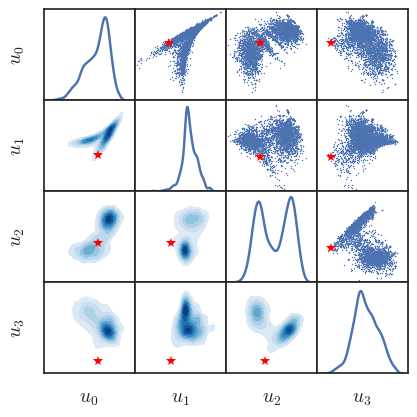

2017-04-19 03:45:02 root:INFO ...run 1 completed: time taken 75.9s, accepted 0.163645454545
2017-04-19 03:45:02 root:INFO Start runs for epsilon=10
2017-04-19 03:45:02 root:INFO Starting run 1...


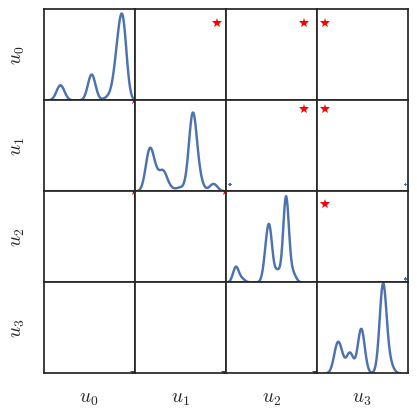

2017-04-19 03:46:36 root:INFO ...run 1 completed: time taken 75.7s, accepted 8.63636363636e-05


In [26]:
for epsilon, step_size in [(100, 0.2), (10, 0.001)]:
    logger.info('Start runs for epsilon={0}'.format(epsilon))
    pmmh_sampler = pm_samplers.PMMHSampler(
        lambda u_z: log_f_estimator(
            u_z, rng.normal(size=consts['n_step'] * 2), epsilon),
        None, prop_sampler, np.ones(consts['n_param']) * step_size, rng
    )
    for r in range(n_run):
        u_z_init = u_inits[r, :consts['n_param']]
        logger.info('Starting run {0}...'.format(r+1))
        start_time = timer()
        u_z_pmmh, n_reject = pmmh_sampler.get_samples(u_z_init.copy(), n_sample + n_warm_up)
        run_time = timer() - start_time
        accept = 1. - n_reject / float(n_sample + n_warm_up)
        if (n_sample + n_warm_up - n_reject) > 1:
            fig, axes = scatter_grid(
                u_z_pmmh[n_warm_up::50], u_obs[0, :consts['n_param']], (4, 4))
            plt.show()
        logger.info('...run {0} completed: time taken {1:.1f}s, accepted {2}'
                    .format(r+1, run_time, accept))
        np.savez(os.path.join(exp_dir, 'pmmh-gauss-eps-{0}-results-{1}.npz'.format(epsilon, r + 1)),
                 u_z_pmmh=u_z_pmmh, accept=accept, run_time=run_time, 
                 step_size=step_size, n_warm_up=n_warm_up)

## PM Slice (Ell) ABC MCMC (Gaussian kernel)

In [27]:
def log_f_estimator_ess(u_z, u_y, epsilon):
    y = model.generator_func(np.r_[u_z, u_y])
    diff = y - model.y_obs
    return -0.5 * ((diff / epsilon)**2).sum()

In [30]:
n_sample = 15000
n_warm_up = 1000
rng.seed(consts['seed'])

2017-04-19 03:51:48 root:INFO Start runs for epsilon=100
2017-04-19 03:51:48 root:INFO Starting run 1...


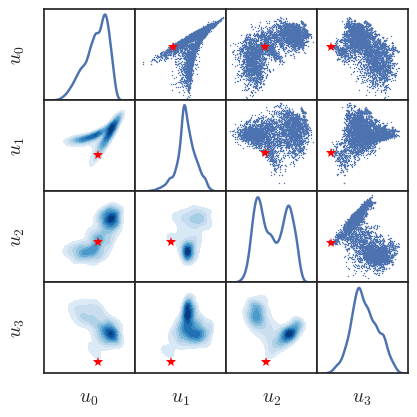

2017-04-19 03:52:58 root:INFO ...run 1 completed: time taken 49.0s
2017-04-19 03:52:58 root:INFO Start runs for epsilon=10
2017-04-19 03:52:58 root:INFO Starting run 1...


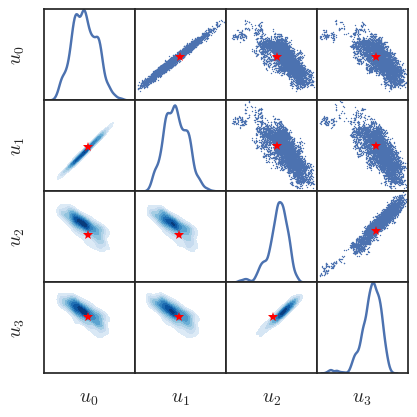

2017-04-19 03:54:46 root:INFO ...run 1 completed: time taken 87.7s
2017-04-19 03:54:46 root:INFO Start runs for epsilon=1
2017-04-19 03:54:46 root:INFO Starting run 1...


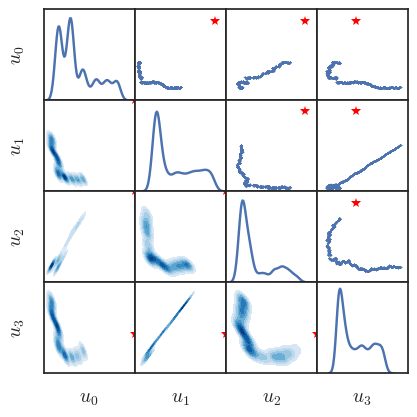

2017-04-19 03:57:29 root:INFO ...run 1 completed: time taken 138.0s


In [31]:
for epsilon in [100, 10, 1]:
    logger.info('Start runs for epsilon={0}'.format(epsilon))
    pmess_sampler = pm_samplers.APMEllSSPlusEllSSSampler(
        lambda u_y, u_z, cached=None: (
            log_f_estimator_ess(u_z, u_y, epsilon), None),
        lambda: rng.normal(size=consts['n_step'] * 2),
        lambda: rng.normal(size=consts['n_param']), rng, 100
    )
    for r in range(n_run):
        u_z_init = u_inits[r, :consts['n_param']]
        u_y_init = u_inits[r, consts['n_param']:]
        logger.info('Starting run {0}...'.format(r+1))
        start_time = timer()
        u_z_pmess = pmess_sampler.get_samples(
            u_z_init.copy(), n_sample + n_warm_up, u_y_init.copy())
        run_time = timer() - start_time
        fig, axes = scatter_grid(
            u_z_pmess[n_warm_up::3], u_obs[0, :consts['n_param']], (4, 4))
        plt.show()
        logger.info('...run {0} completed: time taken {1:.1f}s'
                    .format(r+1, run_time))
        np.savez(os.path.join(exp_dir, 'pmess-gauss-eps-{0}-results-{1}.npz'.format(epsilon, r + 1)),
                 epsilon=epsilon, u_z_pmess=u_z_pmess, run_time=run_time, n_warm_up=n_warm_up)

## ABC HMC (Gaussian kernel)

In [32]:
u = tt.vector('u')
y = lotka_volterra.population_seq_generator(u, consts)
epsilon = tt.scalar('epsilon')
energy = (
    0.5 * ((model.y_obs - y)**2 / epsilon**2).sum() + 
    0.5 * u.dot(u)
)
abc_energy_func = th.function([u, epsilon], energy)
abc_energy_grad = th.function([u, epsilon], tt.grad(energy, u))

Set up the unconstrained HMC sampler with the compiled energy function / gradient and define sampler settings.

In [ ]:
n_step_per_sample = (10, 20)
n_warm_up = 200
n_sample = 2000
rng.seed(consts['seed'])

Run sampling and visualise computed samples as grids of images.

In [ ]:
for epsilon, dt in [(100, 0.025), (10, 0.0025), (1, 0.00025)]:
    logger.info('Start runs for epsilon={0}'.format(epsilon))
    abc_hmc_sampler = hmc.unconstrained.IsotropicHmcSampler(
        lambda u, cache={}: abc_energy_func(u, epsilon), 
        lambda u, cache={}: abc_energy_grad(u, epsilon), rng
    )
    for r in range(n_run):
        try:
            u_init = u_inits[r]
            logger.info('Starting run {0}...'.format(r+1))
            start_time = timer()
            u_samples, mom_samples, accept = abc_hmc_sampler.get_samples(
                pos=u_init * 1., dt=dt,  n_step_per_sample=n_step_per_sample, 
                n_sample=n_sample + n_warm_up)
            run_time = timer() - start_time
            logger.info('...completed, accepted: {0}, run time: {1:.1f}s'
                        .format(accept, run_time))
            fig, axes = scatter_grid(
                u_samples[n_warm_up:, :consts['n_param']], 
                u_obs[0, :consts['n_param']], (4, 4))
            plt.show()
            np.savez(os.path.join(exp_dir, 'abc-hmc-eps-{0}-results-{1}.npz'.format(epsilon, r + 1)),
                u_samples=u_samples, accept=accept, run_time=run_time, 
                n_step_per_sample=n_step_per_sample, dt=dt, n_warm_up=n_warm_up)
        except Exception as e:
            logger.exception('Error encountered run {0}:'.format(r+1))

2017-04-19 03:59:42 root:INFO Start runs for epsilon=100
2017-04-19 03:59:42 root:INFO Starting run 1...
